In [101]:
# Install MySql packages
# conda update -n base -c conda-forge conda --yes
# !pip install ipython-sql
# !pip install mysql-connector-python
# !conda install -c conda-forge python-dotenv --yes

In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels as sm
import mysql.connector
from mysql.connector import Error
from os import environ, path
from dotenv import load_dotenv

In [103]:
# Read enviromental variables to connect the database
load_dotenv()
password = environ.get('PASSWORD')
host = environ.get('HOST')
database = environ.get('DATABASE')

## Connect to the database and create dataframes for each table

In [104]:
try:
    connection = mysql.connector.connect(host=host ,
                                        database=database,
                                        user='root',
                                        password=password)
    if connection.is_connected():
        print("Succes Connected")
    df_musician = pd.read_sql_query("SELECT * FROM music_and_death.musician;", connection)
    df_birth = pd.read_sql_query("SELECT * FROM music_and_death.birth;", connection)
    df_death = pd.read_sql_query("SELECT * FROM music_and_death.death;", connection)
    df_genre = pd.read_sql_query("SELECT * FROM music_and_death.music_genre;", connection)
    genre = pd.read_sql_query("SELECT * FROM music_and_death.genre;", connection)
    cause_death = pd.read_sql_query("SELECT * FROM music_and_death.cause_death;", connection)
    cities = pd.read_sql_query("SELECT * FROM music_and_death.cities;", connection)
    states = pd.read_sql_query("SELECT * FROM music_and_death.states;", connection)
    countries = pd.read_sql_query("SELECT * FROM music_and_death.countries;", connection)
    
    
except Error as e:
    print("Error closing connection")

# Concatenate tables
else:
    # Concatenate musician and death dataframes
    df = pd.concat([df_musician, df_birth], axis=1)
    df = pd.concat([df, df_death], axis=1)
    df = pd.merge(df, cause_death, on=["death_id", "death_id"])
    df = df.loc[:, ~df.columns.duplicated()].copy()
    df = pd.merge(df, df_genre, on=["musician_id"])
    df = df.loc[:, ~df.columns.duplicated()].copy()
    df = pd.merge(df, genre, on=["genre_id"])
    # rearrange columns
    df = df.iloc[:, [0, 1, 2, 3, 5, 7, 8, 9, 11, 6, 4, 10]]
    
finally:
    connection.close()

Succes Connected


## Merge and clean the cities, states and countries tables

In [105]:
# merge cities table with states table
place = cities.merge(states, 
                      left_on=cities["state_id"], 
                      right_on=states["id"])

# drop duplicate keys
place.drop(['key_0', 'state_id', 'id_y'], axis=1, inplace=True)

# merge resulted table with countries table
place = place.merge(countries, 
                        left_on=place["country_id"],
                        right_on=countries["id"])

# drop duplicated keys
place.drop(['key_0', 'country_id', 'id', 'iso2', 'capital'], 
              axis=1, 
              inplace=True)

# rename column names
place.rename(
    columns={'name_x': 'City', 
             'name_y': 'State', 
             'name': 'Country', 
             'id_x': 'city_id'},
    inplace=True
)

##  Drop columns with not use

In [106]:
df.drop(['middle_name', 'death_id', "death_date", "genre_id", "birth"], 
        axis=1, 
        inplace=True)

In [107]:
df

,musician_id,stage_name,stage_lastname,death_age,cause,genre,birthplace_id
0,1,John,Lennon,40,homicide,rock,50337
1,2,Kurt,Cobain,27,suicide,rock,110979
2,17,Chris,Cornell,52,suicide,rock,126104
3,18,Chester,Bennington,41,suicide,rock,124148
4,32,Ian,Curtis,23,suicide,rock,51499
...,...,...,...,...,...,...,...
278,148,A.,Carter,68,unknown,country,126050
279,241,Baby,Huey,26,drug overdose,funk,125084
280,175,Richard,Fariña,29,car/motorcycle accident,folk,122795
281,190,Woody,Guthrie,55,brain disorder,folk,123401


In [108]:
place

,city_id,City,State,Country
0,52,Ashkāsham,Badakhshan,Afghanistan
1,68,Fayzabad,Badakhshan,Afghanistan
2,78,Jurm,Badakhshan,Afghanistan
3,84,Khandūd,Badakhshan,Afghanistan
4,115,Rāghistān,Badakhshan,Afghanistan
...,...,...,...,...
148261,131496,Redcliff,Midlands Province,Zimbabwe
148262,131502,Shangani,Midlands Province,Zimbabwe
148263,131503,Shurugwi,Midlands Province,Zimbabwe
148264,131504,Shurugwi District,Midlands Province,Zimbabwe


## Merge musician info dataframe with place dataframe

In [109]:
# merge df and place dataframes
musician = df.merge(place, 
                    left_on=df['birthplace_id'], 
                    right_on=place['city_id'])

# drop unused columns
musician.drop(['birthplace_id', 'city_id', 'key_0'], axis=1, inplace=True)

In [110]:
musician

,musician_id,stage_name,stage_lastname,death_age,cause,genre,City,State,Country
0,1,John,Lennon,40,homicide,rock,Liverpool,England,United Kingdom
1,271,Rory,Storm,34,suicide,rock,Liverpool,England,United Kingdom
2,188,Brian,Epstein,32,drug overdose,rock,Liverpool,England,United Kingdom
3,2,Kurt,Cobain,27,suicide,rock,Aberdeen,Washington,United States
4,17,Chris,Cornell,52,suicide,rock,Seattle,Washington,United States
...,...,...,...,...,...,...,...,...,...
277,37,Johnny,Cash,71,diabetes,country,Cleveland County,Arkansas,United States
278,148,A.,Carter,68,unknown,country,Scott County,Virginia,United States
279,241,Baby,Huey,26,drug overdose,funk,Richmond,Indiana,United States
280,190,Woody,Guthrie,55,brain disorder,folk,Okemah,Oklahoma,United States


## Create plots to observe the data

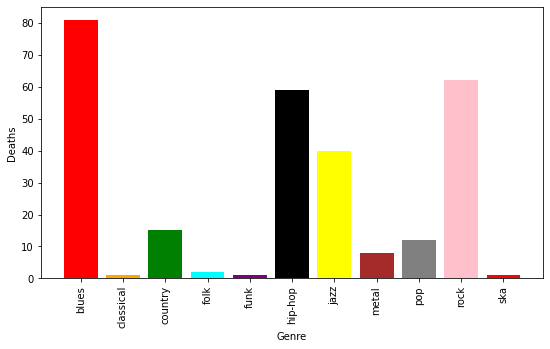

In [111]:
# Bar plot to show deaths per music genre 

# Create a new music table using genre as indez and size of each genre
df_n = musician.pivot_table(index=['genre'], aggfunc='size')

# plot the data
plt.figure(figsize=(9,5))
plt.bar(df_n.index, df_n, color=
        ['red', 'orange', 'green',
         'cyan', 'purple', 'black',
         'yellow', 'brown', 'grey', 'pink'])
plt.ylabel("Deaths")
plt.xlabel("Genre")
plt.xticks(rotation='vertical')
plt.show()

## Cause of death per music genre

In [112]:
df_cd = musician.pivot_table(index=['cause', 'genre'], aggfunc='size')
df_cd

cause                              genre  
AIDS                               pop        1
                                   rock       1
Burned                             blues      1
Falling                            rock       1
accidental self-inflicted gunshot  blues      1
                                             ..
tuberculosis                       blues      1
                                   jazz       1
unknown                            blues      9
                                   country    1
                                   jazz       8
Length: 70, dtype: int64

# Questions

## Most common Death Ages


In [113]:
n_da = musician['death_age'].value_counts().nlargest(15)

In [114]:
n_da

27    19
32    11
37    10
28    10
21     9
25     9
34     9
24     8
30     8
36     7
40     7
39     7
29     7
33     7
53     6
Name: death_age, dtype: int64

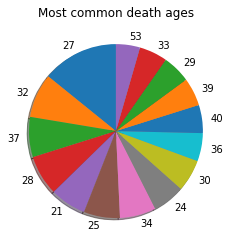

In [115]:

plt.pie(n_da.values, labels=n_da.index, startangle=90, shadow=True)
plt.title("Most common death ages")
# plt.legend(title='Death age', loc=(1, 0.25))
plt.show()

In [116]:
n_da.values

array([19, 11, 10, 10,  9,  9,  9,  8,  8,  7,  7,  7,  7,  7,  6],
      dtype=int64)

## Most common Music Genre

In [117]:
n_mg = musician['genre'].value_counts()

In [118]:
n_mg

blues        81
rock         62
hip-hop      59
jazz         40
country      15
pop          12
metal         8
folk          2
funk          1
classical     1
ska           1
Name: genre, dtype: int64

<BarContainer object of 11 artists>

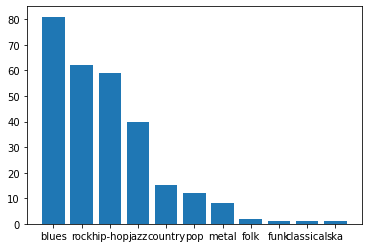

In [119]:
plt.bar(n_mg.index, n_mg.values)

# Places

### Most common Countries

In [120]:
n_places = musician['Country'].value_counts()

In [121]:
n_places

United States     231
United Kingdom     25
Germany             3
Lithuania           2
Canada              2
Australia           2
Jamaica             2
Turkey              1
Greece              1
Norway              1
Netherlands         1
South Africa        1
Brazil              1
New Zealand         1
Sweden              1
India               1
Colombia            1
Tanzania            1
Finland             1
Mexico              1
Haiti               1
Belarus             1
Name: Country, dtype: int64

### Most common States

In [122]:
n_states = musician['State'].value_counts().nlargest(20)

In [123]:
n_states

New York          27
Mississippi       26
England           20
California        20
Texas             18
Louisiana         16
Tennessee         15
Georgia           12
Alabama           12
Pennsylvania       8
Illinois           6
Arkansas           6
Washington         6
Missouri           6
Scotland           5
Ohio               5
Virginia           5
North Carolina     4
Indiana            4
Florida            4
Name: State, dtype: int64

### Most common Cities

In [124]:
n_cities = musician['City'].value_counts().nlargest(20)

In [125]:
n_cities

New York City    16
New Orleans       9
Los Angeles       8
Memphis           7
London            7
Philadelphia      6
Birmingham        5
Chicago           5
Queens            4
Liverpool         3
Richmond          3
Dallas            3
Atlanta           3
Como              2
Melbourne         2
Kingston          2
Louisiana         2
Oakland           2
Glasgow           2
Houston           2
Name: City, dtype: int64

## Death genre - cause

In [126]:
n_cd_gr = musician.loc[:, ['genre', 'cause']].value_counts()

In [127]:
n_cd_gr

genre    cause                            
hip-hop  homicide                             58
blues    heart disease                        20
         cancer                               12
jazz     heart disease                        11
rock     drug overdose                        11
                                              ..
blues    accidental self-inflicted gunshot     1
jazz     suicide                               1
         tuberculosis                          1
metal    aircraft accident                     1
ska      suicide                               1
Length: 70, dtype: int64

In [128]:
n_cd_gr = n_cd_gr.reset_index()
n_cd_gr.rename(columns={0: 'deaths'}, inplace=True)

In [129]:
n_cd_gr

,genre,cause,deaths
0,hip-hop,homicide,58
1,blues,heart disease,20
2,blues,cancer,12
3,jazz,heart disease,11
4,rock,drug overdose,11
...,...,...,...
65,blues,accidental self-inflicted gunshot,1
66,jazz,suicide,1
67,jazz,tuberculosis,1
68,metal,aircraft accident,1


### Blues 

In [130]:
n_blues = n_cd_gr.loc[n_cd_gr['genre'] == 'blues', ]

In [131]:
n_blues

,genre,cause,deaths
1,blues,heart disease,20
2,blues,cancer,12
5,blues,unknown,9
11,blues,homicide,7
12,blues,diabetes,5
13,blues,car/motorcycle accident,5
14,blues,pneumonia,5
18,blues,brain disorder,4
25,blues,aircraft accident,3
32,blues,drug overdose,2


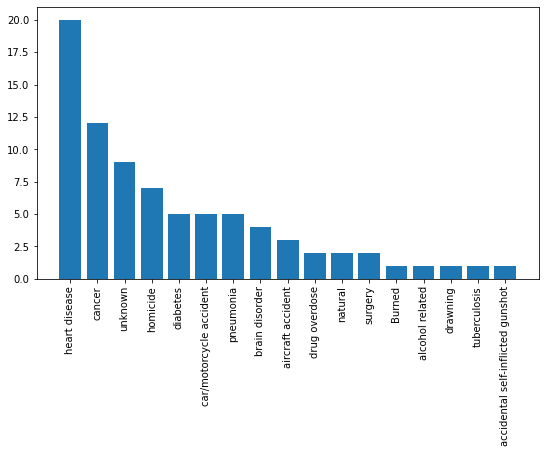

In [132]:
plt.figure(figsize=(9,5))
plt.bar(n_blues['cause'], n_blues['deaths'])
plt.xticks(rotation='vertical')
plt.show()


### Rock

In [133]:
n_rock = n_cd_gr.loc[n_cd_gr['genre'] == 'rock', ]

In [134]:
n_rock

,genre,cause,deaths
4,rock,drug overdose,11
6,rock,car/motorcycle accident,9
7,rock,suicide,9
8,rock,alcohol related,8
10,rock,heart disease,7
16,rock,drawning,4
21,rock,aircraft accident,3
26,rock,cancer,2
31,rock,pneumonia,2
34,rock,brain disorder,2


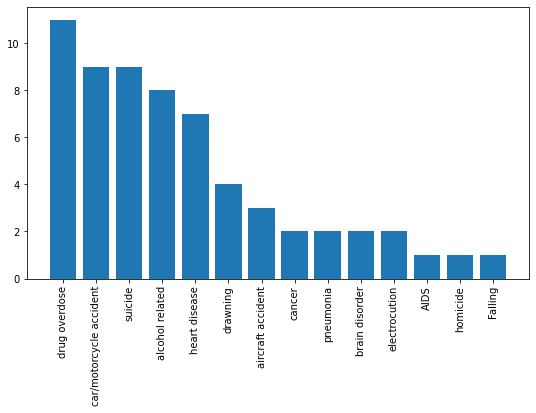

In [135]:
plt.figure(figsize=(9,5))
plt.bar(n_rock['cause'], n_rock['deaths'])
plt.xticks(rotation='vertical')

plt.show()

### Rock vs Blues

In [136]:
n_cause = n_cd_gr['cause'].unique()
n_blues_deaths = n_blues['deaths']
n_rock_deaths = n_rock['deaths']
x_axis = np.arange(len(n_cause))

## Most common Cause o deaths

In [137]:
n_cause_death = musician['cause'].value_counts()

In [138]:
n_cause_death

homicide                             70
heart disease                        45
drug overdose                        22
car/motorcycle accident              22
cancer                               21
unknown                              18
suicide                              13
aircraft accident                    13
brain disorder                       11
pneumonia                            10
alcohol related                      10
diabetes                              7
drawning                              6
natural                               2
AIDS                                  2
surgery                               2
tuberculosis                          2
electrocution                         2
Burned                                1
kidney related                        1
accidental self-inflicted gunshot     1
Falling                               1
Name: cause, dtype: int64

# Correlation

### Genre - Cause of death

### Age - Cause of death

### Genre - Age